# Получаем номера задачек и всё такое

In [296]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import regex as re
import scipy.stats as st
import numpy as np
import nltk
from collections import Counter
%matplotlib inline
from scipy.stats.stats import pearsonr
import statsmodels.formula.api as smf
from scipy.stats import skew
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from functools import reduce
from statsmodels.api import GLM

In [ ]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('Enter phystech e-mail\n') 
    seed = crc32(mail.strip().encode('utf-8'))%(2**32 - 1)
    rs = np.random.RandomState(seed)
    print('Your tasks are:')
    print(
        '1.{}, 2.{}, 3.{}, 4.{}, 5.{}, 6.{}'.format(
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=4), 
            rs.randint(low=1, high=3), 
            rs.randint(low=1, high=3)))

Enter phystech e-mail
zhestov.ea@phystech.edu
Your tasks are:
1.4, 2.3, 3.2, 4.2, 5.1, 6.1


# Задание 1 (сделано)
## Задача 1.4
Частота распределения слов в языке описывается [законом Ципфа](https://en.wikipedia.org/wiki/Zipf%27s_law).

Проверить, что он действительно описывает частоту слов (через формальный критерий) на основе анализа двух документов: [Анны Карениной](http://az.lib.ru/t/tolstoj_lew_nikolaewich/text_0080.shtml) и [новостного корпуса](https://object.pouta.csc.fi/OPUS-WMT-News/v2019/mono/ru.txt.gz). Можно ли утверждать, что параметры закона Ципфа для этих двух корпусов совпадают?

Пояснение по закону Ципфа: закон Ципфа утверждает, что в выборке из $N$ элементов частота (вероятность) встретить элемент с рангом $K$ равняется: $const / K^a$, где $a$ --- параметр распределения. [Подробнее можно посмотреть здесь.](https://statweb.stanford.edu/~owen/courses/306a/ZipfByHera.pdf)

### Загрузка данных и первичное исследование

In [115]:
!mkdir data
!mkdir data/texts
!wget https://raw.githubusercontent.com/yk4r2/AppliedStats/main/MIPT/labs/lab1/data/anna-karenina.txt -O data/texts/anna-karenina.txt
!wget https://raw.githubusercontent.com/yk4r2/AppliedStats/main/MIPT/labs/lab1/data/corpus.txt -O data/texts/corpus.txt

mkdir: cannot create directory ‘data’: File exists
--2021-04-05 15:08:28--  https://raw.githubusercontent.com/yk4r2/AppliedStats/main/MIPT/labs/lab1/data/anna-karenina.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3255586 (3.1M) [text/plain]
Saving to: ‘data/texts/anna-karenina.txt’

data/texts/anna-kar 100%[===================>]   3.10M  --.-KB/s    in 0.02s   

2021-04-05 15:08:28 (134 MB/s) - ‘data/texts/anna-karenina.txt’ saved [3255586/3255586]

--2021-04-05 15:08:28--  https://raw.githubusercontent.com/yk4r2/AppliedStats/main/MIPT/labs/lab1/data/corpus.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [116]:
with open('data/texts/anna-karenina.txt') as f:
    ann_kar = f.readlines()
f.close()

with open('data/texts/corpus.txt') as f:
    corpus = f.readlines()
f.close()

In [117]:
ann_kar[len(ann_kar) - 1000:len(ann_kar) - 990]

['\n',
 '\n',
 '\n',
 '\n',
 'ни с того ни с сего (франц.).\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n']

Выглядит очень ужасно. Будем исправлять.

In [118]:
def super_seducer(line: str):
    return re.sub(r'[^\P{P}-]+', '', line).strip('\n').lstrip(' ').lower()

In [119]:
new_kar = list(filter(lambda x: len(x) > 1, map(super_seducer, ann_kar)))

In [120]:
new_kar[:2]

['annotation',
 'анна каренина один из самых знаменитых романов льва толстого начинается ставшей афоризмом фразой все счастливые семьи похожи друг на друга каждая несчастливая семья несчастлива по-своему это книга о вечных ценностях о любви о вере о семье о человеческом достоинстве']

In [121]:
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [122]:
tokens_kar = nltk.word_tokenize(' '.join(new_kar))
count_kar = sorted(Counter(tokens_kar).items(), key = lambda item: item[1], reverse=True)

In [123]:
rank_kar = [(x[1], i+1) for i, x in enumerate(count_kar)]

In [124]:
new_corpus = list(filter(lambda x: len(x) > 1, map(super_seducer, corpus)))
tokens_corpus = nltk.word_tokenize(' '.join(new_corpus))
count_corpus = sorted(Counter(tokens_corpus).items(), key = lambda item: item[1], reverse=True)
rank_corpus = [(x[1], i+1) for i, x in enumerate(count_corpus)]

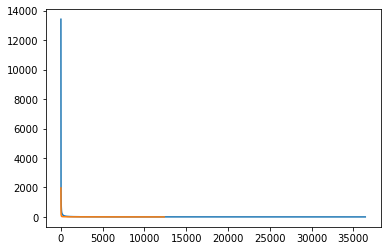

In [125]:
plt.plot(np.transpose(rank_kar)[1], np.transpose(rank_kar)[0])
plt.plot(np.transpose(rank_corpus)[1], np.transpose(rank_corpus)[0])
plt.show()

Идея с loglog координатами нагло подрезана [отсюда](https://statweb.stanford.edu/~owen/courses/306a/ZipfByHera.pdf#page16)

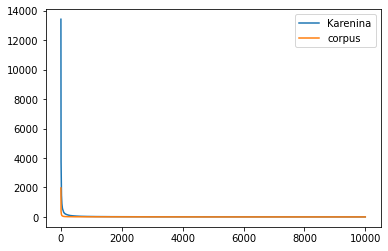

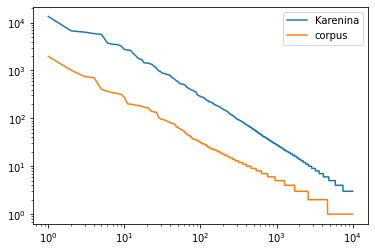

In [126]:
plotter_kar = np.transpose(rank_kar[:int(1e4)])
plotter_corpus = np.transpose(rank_corpus[:int(1e4)])

plt.plot(plotter_kar[1], plotter_kar[0], label='Karenina')
plt.plot(plotter_corpus[1], plotter_corpus[0], label='corpus')
plt.legend()
plt.show()

# логарифмируем, чёб нет
plt.loglog(plotter_kar[1], plotter_kar[0], label='Karenina')
plt.loglog(plotter_corpus[1], plotter_corpus[0], label='corpus')
plt.legend()
plt.show()

### Мои мысли по поводу задачи и попытка решения

1. Проверка того, что он действительно описывает частоту слов: т.к. Zipf's law похож на power law, а оценить, по факту, нам нужно только коэффициент, мы можем сделать линейную регрессию в логлог координатах, посмотреть на параметры, сказать, что линия соблюдается (или не соблюдается)
2. Теперь мы можем сравнить два линрега с гипотезой коэффициент от 1й равен к-ту от 2й, что, как мы видим из графика, не должно подтвердиться.
3. Буду работать с первыми 10e4 слов, потому что предобработка текста выполнена без учёта возвращения слов к нормальной форме и всего такого.

In [127]:
data = pd.DataFrame({'kar': np.log(plotter_kar[0]), 'corpus': np.log(plotter_corpus[0]), 'rank': plotter_kar[1]})

model_1 = smf.ols('kar ~ rank', data=data).fit()
model_2 = smf.ols('corpus ~ rank', data=data).fit()

In [128]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    kar   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                 3.001e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:09:18   Log-Likelihood:                -7526.6
No. Observations:               10000   AIC:                         1.506e+04
Df Residuals:                    9998   BIC:                         1.507e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5390      0.010    344.457      0.000       3.519       3.559
rank          -0.0003   1.78e-06   -173.236      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     7610.639   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189172.195
Skew:                           3.464   Prob(JB):                         0.00
Kurtosis:                      23.150   Cond. No.                     1.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 corpus   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                 2.243e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:09:18   Log-Likelihood:                -6364.1
No. Observations:               10000   AIC:                         1.273e+04
Df Residuals:                    9998   BIC:                         1.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7767      0.009    194.244      0.000       1.759       1.795
rank          -0.0002   1.58e-06   -149.782      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     6695.960   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           155534.714
Skew:                           2.878   Prob(JB):                         0.00
Kurtosis:                      21.443   Cond. No.                     1.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

По всем показателям, которые я умею определять, модельки вышли неплохими. Я посмотрел на `pvalue` и на `rsquared` вместе с `F`.

Выходит, что эта штука и правда подчиняется закону Ципфа.

Теперь нетривиальная часть: как же нам понять, что параметр $\alpha$ у двух распределений равен?

Придумалось вот что: если мы "перевернём" модель, т.е. сделаем не $y_i(x), \quad x\in\{1, 2\}$, а $x(y_1, y_2)$, то мы сможем отловить автокорреляцию $y_1$ и $y_2$, ибо они в случае правильности гипотезы о том, что $\alpha_1 = \alpha_2$, они будут ЛЗ.

Останется только использовать какой-нибудь тест на автокорреляцию модели и дело в шляпе.

In [130]:
model_autocorr = smf.ols('rank ~ kar + corpus', data=data).fit()
model_autocorr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 1.570e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:09:20   Log-Likelihood:                -86764.
No. Observations:               10000   AIC:                         1.735e+05
Df Residuals:                    9997   BIC:                         1.736e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.148e+04     92.130    124.558      0.000    1.13e+04    1.17e+04
kar        -3727.9417     70.930    -52.558      0.000   -3866.980   -3588.904
corpus      1646.6077     88.492     18.607      0.000    1473.145    1820.070
==============================================================================
Omnibus:                     2460.405   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8634.981
Skew:                           1.214   Prob(JB):                         0.00
Kurtosis:                       6.851   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
model_autocorr.wald_test('kar = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2762.31756998]]), p=0.0, df_denom=1e+04, df_num=1>

Я НАШЁЛ АВТОКОРРЕЛЯЦИЮ, а значит, $\alpha$ и правда равны.


А почему так нетривиально???

По факту: я мог просто взять и сравнить распределения хи-квадратом, но я тупой.

# Задание 2 (сделано)
## Задача 2.3
Известно, что электричка "Вашингтон-Петушки" аварийно останавливается раз в несколько дней. Аналитики РЖД проанализировали, сколько дней электричка едет без поломок, и составили выборку: $x = (3, 22, 13, 6, 18, 5, 6, 10, 7, 15)$.

РЖД хочет проверить гипотезу, что дисперсия распределения равна 9 против правосторонней альтернативы.

Требуется:
- Ввести предположение, каким распределением описывается данная выборка.
- Записать задачу формально.
- Предложить критерий для оценки дисперсии распределения.
- Проверить гипотезу о значении дисперсии распределения для уровня значимости $\alpha = 0.05$ аналитически.
- Вывести и получить доверительный интервал для значения дисперсии при $\alpha = 0.05$.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановки численных значений в финальную формулу)

Очевидно, что предположения без компуктера я выдвигать не умею, поэтому сделаю-ка я графичек.

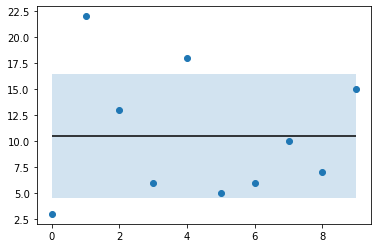

In [ ]:
x = [3, 22, 13, 6, 18, 5, 6, 10, 7, 15]
plt.plot(range(len(x)), x, 'o')
plt.hlines(np.mean(x), 0, 9)
plt.fill_between(range(len(x)), np.mean(x)-np.std(x), np.mean(x)+np.std(x), alpha=0.2)
plt.show()

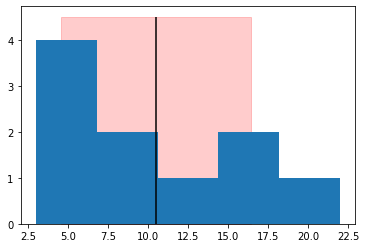

In [ ]:
plt.hist(x, bins=5)
plt.vlines(np.mean(x), 0, 4.5)
plt.fill_betweenx((0, 4.5), np.mean(x)-np.std(x), np.mean(x)+np.std(x), alpha=0.2, color='red')
plt.show()

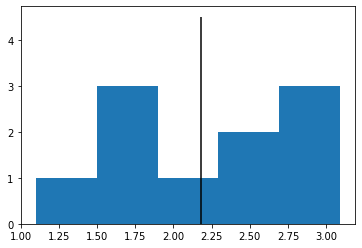

In [ ]:
plt.hist(np.log(x), bins=5)
plt.vlines(np.mean(np.log(x)), 0, 4.5)
plt.show()

Предположение: Данные распределены нормально. Рассмотрим статистику $Q$.

Формулки:
- $Q = \dfrac{\sum_{1}^{n}(\bar{X} - X_i)}{\sigma^2} = \dfrac{S^2 (n-1)}{\sigma^2} \text{ ~ } \chi^2 (n-1)$
- Тогда вероятность $P \left(\chi^2_{1 - \frac{\alpha}{2}, n - 1} < Q < \chi^2_{\frac{\alpha}{2}, n - 1}\right) = 1 - \alpha$
- $P \left(\chi^2_{1 - \frac{\alpha}{2}, n - 1} < \dfrac{S^2(n-1)}{\sigma^2} < \chi^2_{\frac{\alpha}{2}, n - 1}\right) = 1 - \alpha$
- $P \left(\dfrac{S^2(n-1)}{\chi^2_{1 - \frac{\alpha}{2}, n - 1}} < \sigma^2 < \dfrac{S^2(n-1)}{\chi^2_{\frac{\alpha}{2}, n - 1}}\right) = 1 - \alpha$
- Выходит, что $\left[\dfrac{S^2(n-1)}{\chi^2_{1 - \frac{\alpha}{2}, n - 1}}; \dfrac{S^2(n-1)}{\chi^2_{\frac{\alpha}{2}, n - 1}}\right]$

In [290]:
alpha = 0.05
S = np.std(x, ddof=1)
S_2 = S ** 2
chi_st = st.chi2(len(x) - 1)
left = 0
right = S_2 * (len(x) - 1) / chi_st.ppf(alpha)
print(left, right)

0 106.6129231491097


In [292]:
sigma_0 = 9
Q = S_2 * (len(x)-1) / sigma_0 ** 2
1 - chi_st.cdf(Q)

0.8849297659664597

# Задание 3 (сделано)
## Задача 3.2
Дана [статистика бросков](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/nba.csv) для игроков NBA

Выборка представляет собой статистику бросков для различных игроков NBA. Для каждого игрока известны:

1. количество успешных бросков в домашних играх (`score_home`)
2. количество бросков в домашних играх (`atm_home`)
3. количество успешных бросков в гостевых играх (`score_away`)
4. количество бросков в гостевых играх (`atm_away`)

Требуется определить, есть ли разница в успехе бросков у игроков в домашних и гостевых играх.

У какого процента игроков разница в успехе существенна?

О, это же ровно как обсчитывать A/B тест, лол

### Загрузка данных и первичное исследование

In [133]:
!mkdir data/nba
!wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/nba.csv -O data/nba/nba.csv

--2021-04-05 15:10:21--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/nba.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34909 (34K) [text/plain]
Saving to: ‘data/nba/nba.csv’

data/nba/nba.csv    100%[===================>]  34.09K  --.-KB/s    in 0s      

2021-04-05 15:10:21 (118 MB/s) - ‘data/nba/nba.csv’ saved [34909/34909]



In [134]:
nba = pd.read_csv('data/nba/nba.csv', index_col=0)
nba.head()

,player,team,atm_away,atm_home,score_away,score_home,atm_total,score_total
7,A. Johnson,ATL,30,34,24,28,64,52
10,A. Johnson,TOR,63,57,44,38,120,82
15,Abdur-Rahim,SAC,114,124,84,90,238,174
22,Afflalo,DEN,236,284,189,227,520,416
23,Afflalo,DET,75,88,62,67,163,129


In [135]:
nba.describe()

,atm_away,atm_home,score_away,score_home,atm_total,score_total
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,185.638889,196.368590,141.165598,149.669872,382.007479,290.835470
std,254.125852,265.642927,197.747290,207.325642,518.441505,403.973418
min,14.000000,14.000000,7.000000,6.000000,51.000000,17.000000
25%,48.750000,50.000000,35.000000,37.000000,99.750000,73.000000
50%,93.500000,97.500000,69.500000,71.000000,190.500000,137.000000
75%,212.250000,225.500000,159.250000,167.250000,435.500000,331.250000
max,2615.000000,2676.000000,1762.000000,1832.000000,5291.000000,3594.000000


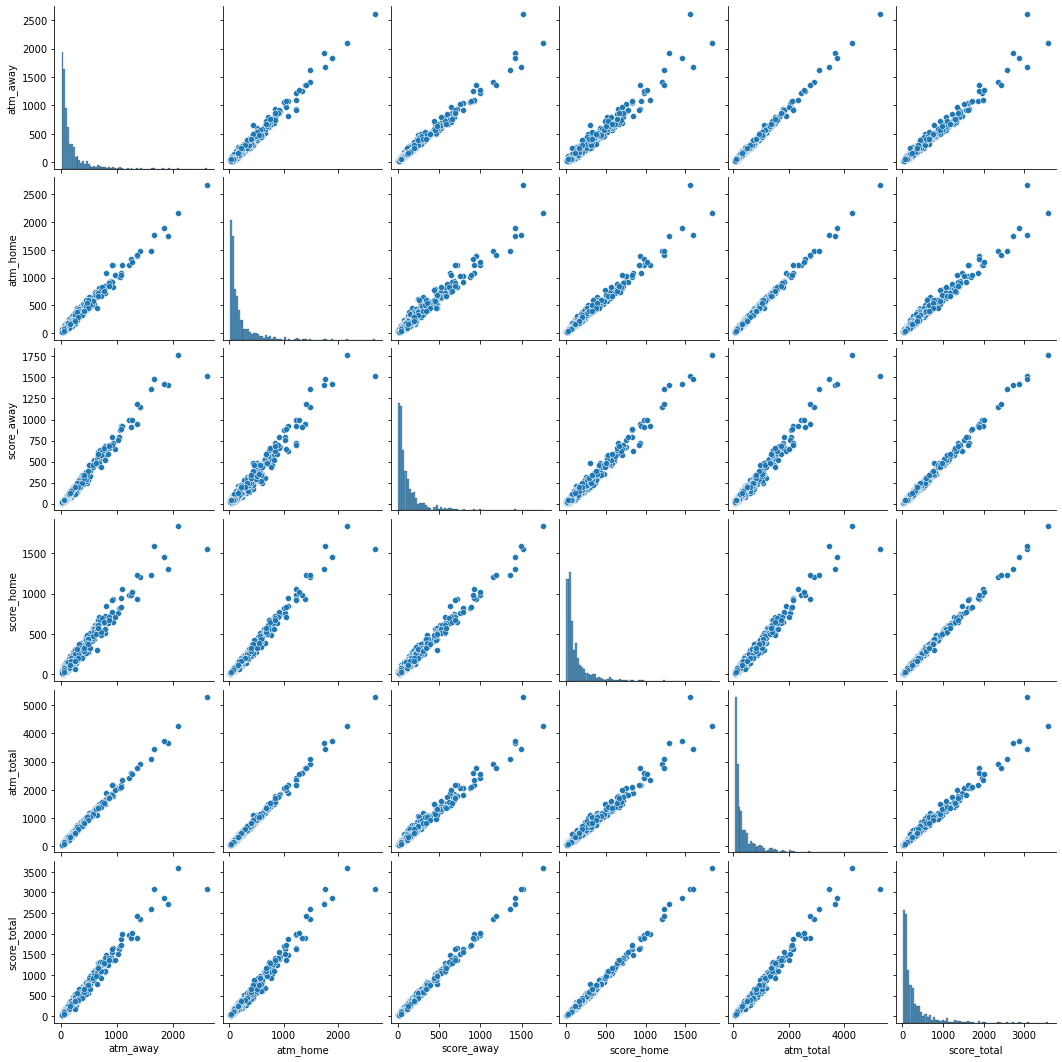

In [136]:
sns.pairplot(nba)

### Решение

Сначала я хотел прологарифмировать, но решил, что можно тупо посчитать вероятности попадания.

Я оставил код с логарифмами, потому что могу, наслаждайтесь.

#### Код с логарифмированием

In [137]:
nba_log = nba
numeric_feats = nba_log.dtypes[nba_log.dtypes == "int"].index

skewed_feats = nba_log[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

nba_log[skewed_feats] = np.log1p(nba_log[skewed_feats])

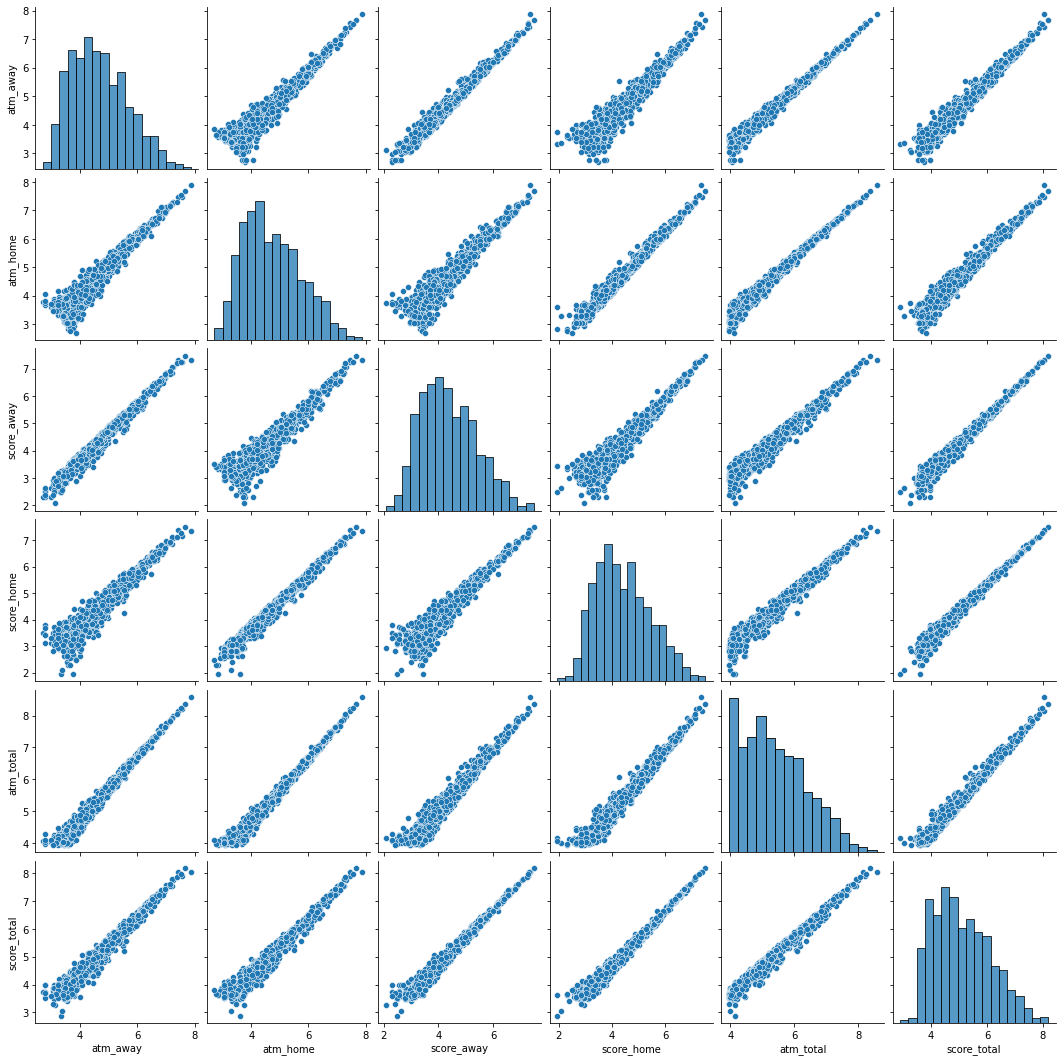

In [138]:
sns.pairplot(nba_log)

Красиво, но бесполезно.

#### Нормальный код

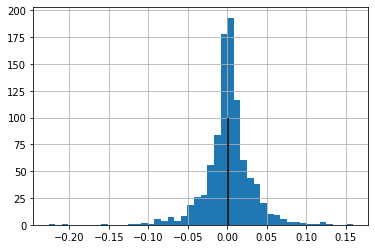

In [139]:
nba['home_prob'] = nba['score_home'] / nba['atm_home']
nba['away_prob'] = nba['score_away'] / nba['atm_away']
plt.hist(nba['home_prob'] - nba['away_prob'], bins=len(nba) // 20)
plt.grid()
plt.vlines(np.mean(nba['home_prob'] - nba['away_prob']), 0, 100)
plt.show()

Спойлер: гипотеза о том, что выборки одинаковые, почти идеально верна. Ща докажем\
А почему у нас не было в курсе поправки Холма-Бонферрони?..

**z-критерий для разности долей**


In [140]:
# так делать нельзя, но если очень лень писать нормальные функции и прописывать колонки, то можно
def first_interval(nba, i: int) -> list:
    return nba['score_home'].iloc[i], nba['score_away'].iloc[i]

def second_interval(nba, i: int) -> list:
    return nba['atm_home'].iloc[i], nba['atm_away'].iloc[i]

def pvals(nba, i: int) -> float:
    return proportions_ztest(first_interval(nba, i), second_interval(nba, i), alternative="two-sided")[1]

nba['pvals'] = list(map(lambda i: pvals(nba, i), range(len(nba))))
nba.head()

,player,team,atm_away,atm_home,score_away,score_home,atm_total,score_total,home_prob,away_prob,pvals
7,A. Johnson,ATL,3.433987,3.555348,3.218876,3.367296,4.174387,3.970292,0.947107,0.937358,0.955926
10,A. Johnson,TOR,4.158883,4.060443,3.806662,3.663562,4.795791,4.418841,0.902257,0.915309,0.948171
15,Abdur-Rahim,SAC,4.744932,4.828314,4.442651,4.510860,5.476464,5.164786,0.934252,0.936294,0.989755
22,Afflalo,DEN,5.468060,5.652489,5.247024,5.429346,6.255750,6.033086,0.960523,0.959577,0.993574
23,Afflalo,DET,4.330733,4.488636,4.143135,4.219508,5.099866,4.867534,0.940042,0.956682,0.911234


Сделаем поправочку на множественное тестирование

In [142]:
multipletests(nba['pvals'], method='bonferroni')[0].sum()

0

Странно, выходит что ни на одного человека не влияет, играет ли он дома или в гостях. Давайте-ка посмотрим на то, сколько людей без поправки играли хуже не дома.

In [143]:
print(len(nba[nba['pvals'] < 0.05]))

0


нуок.

# Задание 4
## Задача 4.2
Рассмотрим данные из [таблицы](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/corona.csv) по числу заболевших и выздоровевших от короновируса в разных странах. Требуется проверить гипотезу о тому, что число выздоровевших людей в странах не зависит от числа заболевших в стране.

Требуется:

1. записать задачу формально;
2. предложить статистику для решения данной задачи;
3. записать приближенно нулевое распределение данной статистики;
4. записать явно правило принятия решения на основе статистики и нулевого распределения для обеспечения уровня значимости $\alpha = 0.05$;
5. проверить гипотезу по записанному критерию, для данных из условия. Противоречат ли они гипотезу?
6. на уровне значимости $\alpha = 0.05$ найти зависимость мощности критерия в зависимости от истинного значения статистики.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановвки численых значений в финальную формулу)

# Задание 5 (сделано)
## Задача 5.1
[Дана выборка](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/regression.zip)

Выборка состоит из трех обзектов: `X_train`, `Y_train`, `X_test`

`Y_train` - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент `X[i,j]` соответствует набору признаков для пикселя `Y[i,j]`).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию $X\to Y$
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по `X_test` (оцениваться будет качество полученного изображения. Ожидается, что регрессия на `X_train`, `Y_train` даст $R^2>0.85$).


### Загрузка данных и первичное исследование

In [144]:
!wget https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/regression.zip?raw=true -O data/regression.zip
!unzip data/regression.zip
!rm -rf data/regression.zip
!mkdir data/regression && mv regression* data/regression/

--2021-04-05 15:11:23--  https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/regression.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Intelligent-Systems-Phystech/psad/raw/master/labs/lab1/data/regression.zip [following]
--2021-04-05 15:11:23--  https://github.com/Intelligent-Systems-Phystech/psad/raw/master/labs/lab1/data/regression.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/regression.zip [following]
--2021-04-05 15:11:23--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/regression.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109

In [267]:
regression_x_test = np.load('data/regression/regression_x_test.npy')
regression_x_train = np.load('data/regression/regression_x_train.npy')
regression_y_train = np.load('data/regression/regression_y_train.npy')

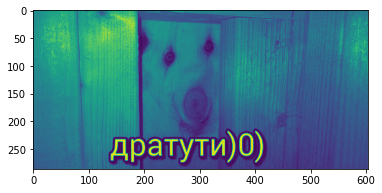

In [154]:
fig, ax = plt.subplots()

ax.imshow(regression_y_train)
plt.show()

In [155]:
regression_x_train.shape

(286, 604, 35)

Код где-то нагло подрезан, но я уже не помню, где

In [239]:
regression_x_train = np.reshape(regression_x_train,
                                (regression_x_train.shape[0] * regression_x_train.shape[1],
                                 regression_x_train.shape[2]
                                 )
                                )
regression_y_train = np.reshape(regression_y_train,
                                (regression_y_train.shape[0] * regression_y_train.shape[1],
                                 )
                                )
regression_x_test = np.reshape(regression_x_test,
                                (regression_x_test.shape[0] * regression_x_test.shape[1],
                                 regression_x_test.shape[2]
                                 )
                                )

train_X = pd.DataFrame(regression_x_train, columns = [i for i in range(1, 36)])
train_Y = pd.DataFrame({'label': regression_y_train})
test_X = pd.DataFrame(regression_x_test, columns = [i for i in range(1, 36)])

train_data = pd.concat((train_X, train_Y), axis=1)

### Начинаем строить модельки

In [185]:
string = reduce(lambda a, x: f'{a} + X{x}', range(36))

model = smf.ols('label ~ ' + string, data=train_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 6.157e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:36:52   Log-Likelihood:             2.2548e+05
No. Observations:              172744   AIC:                        -4.509e+05
Df Residuals:                  172737   BIC:                        -4.509e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1         -1.722e-07   4.71e-10   -365.889      0.000   -1.73e-07   -1.71e-07
X2          1.823e-06   5.36e-09    340.455      0.000    1.81e-06    1.83e-06
X3          2.797e-06   4.39e-09    636.411      0.000    2.79e-06    2.81e-06
X4             0.0160      0.000     42.012      0.000       0.015       0.017
X5             0.0133      0.000     35.243      0.000       0.013       0.014
X6         -1.429e-06   2.68e-09   -533.444      0.000   -1.43e-06   -1.42e-06
X7           3.18e-06   7.59e-09    419.136      0.000    3.17e-06     3.2e-06
X8          1.871e-06   3.18e-09    589.149      0.000    1.87e-06    1.88e-06
X9             0.0160      0.000     42.002      0.000       0.015       0.017
X10            0.0133      0.000     35.245      0.000       0.013       0.014
X11         1.581e-07   2.02e-09     78.293      0.000    1.54e-07    1.62e-07
X12         4.313e-07   5.51e-09     78.293      0.000    4.21e-07    4.42e-07
X13         8.381e-07   1.07e-08     78.293      0.000    8.17e-07    8.59e-07
X14         2.795e-05   3.57e-07     78.293      0.000    2.72e-05    2.86e-05
X15            0.0002   4.96e-07    427.850      0.000       0.000       0.000
X16            0.0001   2.36e-07    427.850      0.000       0.000       0.000
X17            0.0005   1.26e-06    427.850      0.000       0.001       0.001
X18            0.0005    1.2e-06    427.850      0.000       0.001       0.001
X19         4.835e-05   7.63e-08    633.760      0.000    4.82e-05    4.85e-05
X20            0.0003   4.42e-07    633.760      0.000       0.000       0.000
X21            0.0008    1.3e-06    633.760      0.000       0.001       0.001
X22            0.0003   5.51e-07    633.760      0.000       0.000       0.000
X23        -1.426e-06   5.32e-08    -26.782      0.000   -1.53e-06   -1.32e-06
X24        -2.968e-05   1.11e-06    -26.782      0.000   -3.19e-05   -2.75e-05
X25        -2.154e-05   8.04e-07    -26.782      0.000   -2.31e-05      -2e-05
X26        -3.056e-05   1.14e-06    -26.782      0.000   -3.28e-05   -2.83e-05
X27        -7.392e-06   2.69e-07    -27.459      0.000   -7.92e-06   -6.86e-06
X28        -6.281e-06   2.29e-07    -27.459      0.000   -6.73e-06   -5.83e-06
X29        -2.392e-05   8.71e-07    -27.459      0.000   -2.56e-05   -2.22e-05
X30        -4.091e-05   1.49e-06    -27.459      0.000   -4.38e-05    -3.8e-05
X31        -1.334e-06   2.38e-09   -560.112      0.000   -1.34e-06   -1.33e-06
X32         4.107e-06   7.33e-09    560.112      0.000    4.09e-06    4.12e-06
X33        -2.993e-08   5.34e-11   -560.112      0.000      -3e-08   -2.98e-08
X34        -2.345e-06   4.19e-09   -560.112      0.000   -2.35e-06   -2.34e-06
X35         1.824e-06   3.26e-09    560.112      0.000    1.82e-06    1.83e-06
==============================================================================
Om

ща буит мясо и попарная корреляция

In [188]:
GLM.from_formula(f'label ~ X1', data=train_data).fit().pvalues[1]

0.0

Когда-нибудь меня убьют за столько мапредьюсов.\
Я сам не помню уже, зачем их тут столько))

In [201]:
cols = train_data.drop('label', axis=1).columns
pvals = map(lambda x: (GLM.from_formula(f'label ~ {x}', data=train_data).fit().pvalues[1], x), cols)
significant_features = np.transpose(list(filter(lambda item: item[0] < 0.05, pvals)))[1]

In [223]:
string = 'label ~ ' + reduce(lambda a, x: f'{a} + {x}', significant_features)
glm_important = GLM.from_formula(string, data=train_data).fit()

In [211]:
glm_important.wald_test(reduce(lambda a, x: f'{a} = {x}', significant_features) + ' = 0')

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[15007998.18734536]], p-value=0.0, df_denom=6>

### Моделька не удалась, делаем отбор признаков

Ок, придётся анализировать, похоже

Рассортируем дату для начала

In [238]:
binary = []
categorical = []
continuous = []
useless = []
binary_values = {}

for i in range(regression_x_train.shape[2]):
    descr_of_feature = []
    for j in range(regression_x_train.shape[0]):
        for k in range(regression_x_train.shape[1]):
            descr_of_feature.append(regression_x_train[j][k][i])
    if len(set(descr_of_feature)) == 2:
        binary.append(i+1)
        binary_values[i+1] = list(set(descr_of_feature))
    if len(set(descr_of_feature)) > 1000:
        continuous.append(i+1)
    if (len(set(descr_of_feature)) > 2 and len(set(descr_of_feature)) < 1000):
        categorical.append(i+1)
    if len(set(descr_of_feature)) == 1:
        useless.append(i+1)

Приведём в порядок бинарные признаки, чё нам

In [277]:
useless

[31, 32, 33, 34, 35]

In [240]:
train_X = train_X.drop(columns=useless)
test_X = test_X.drop(columns=useless)

In [241]:
for feature in binary_values.keys():
    train_X[feature] = train_X[feature].apply(lambda x: 0 if x == binary_values[feature][0] else 1)
    test_X[feature] = test_X[feature].apply(lambda x: 0 if x == binary_values[feature][0] else 1)

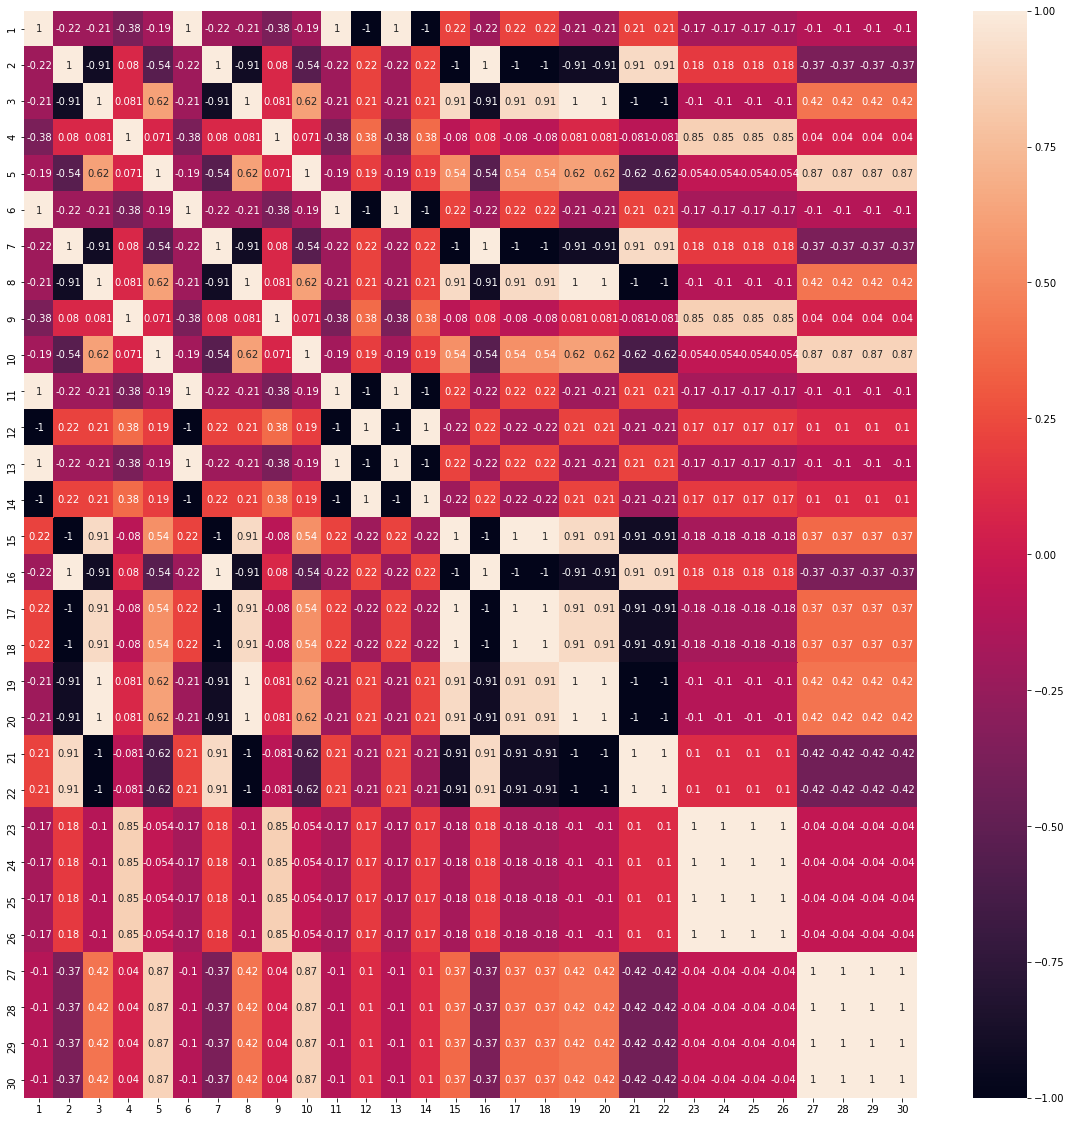

In [244]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_X.corr(), annot=True)

Метод пристального взгляда определил, что можно дропать почти все колонки

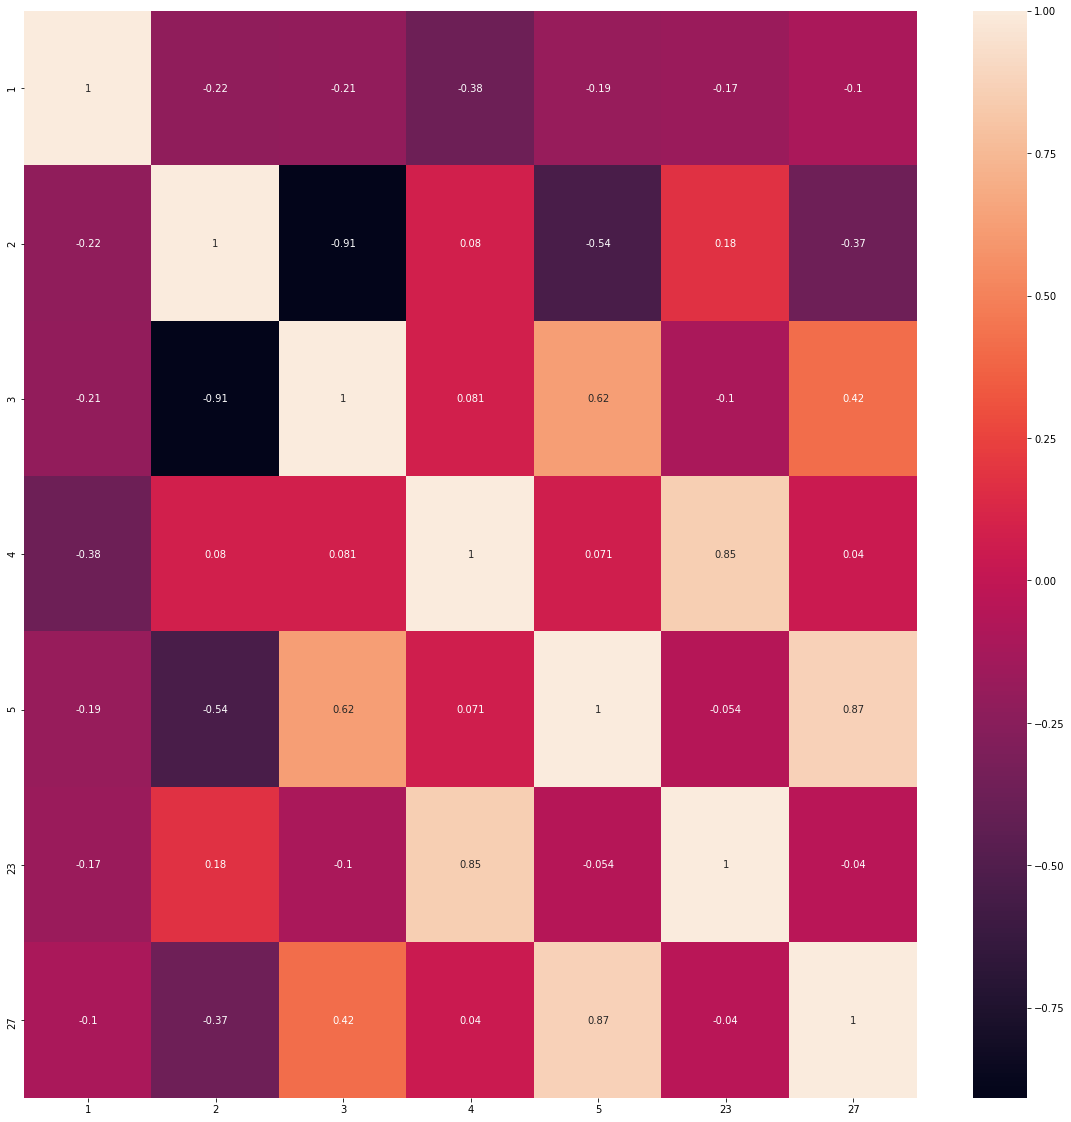

In [247]:
rest = [1,2,3,4,5,23,27]
train_X = train_X[rest]
test_X = test_X[rest]
plt.figure(figsize=(20, 20))
sns.heatmap(train_X.corr(), annot=True)

ok.

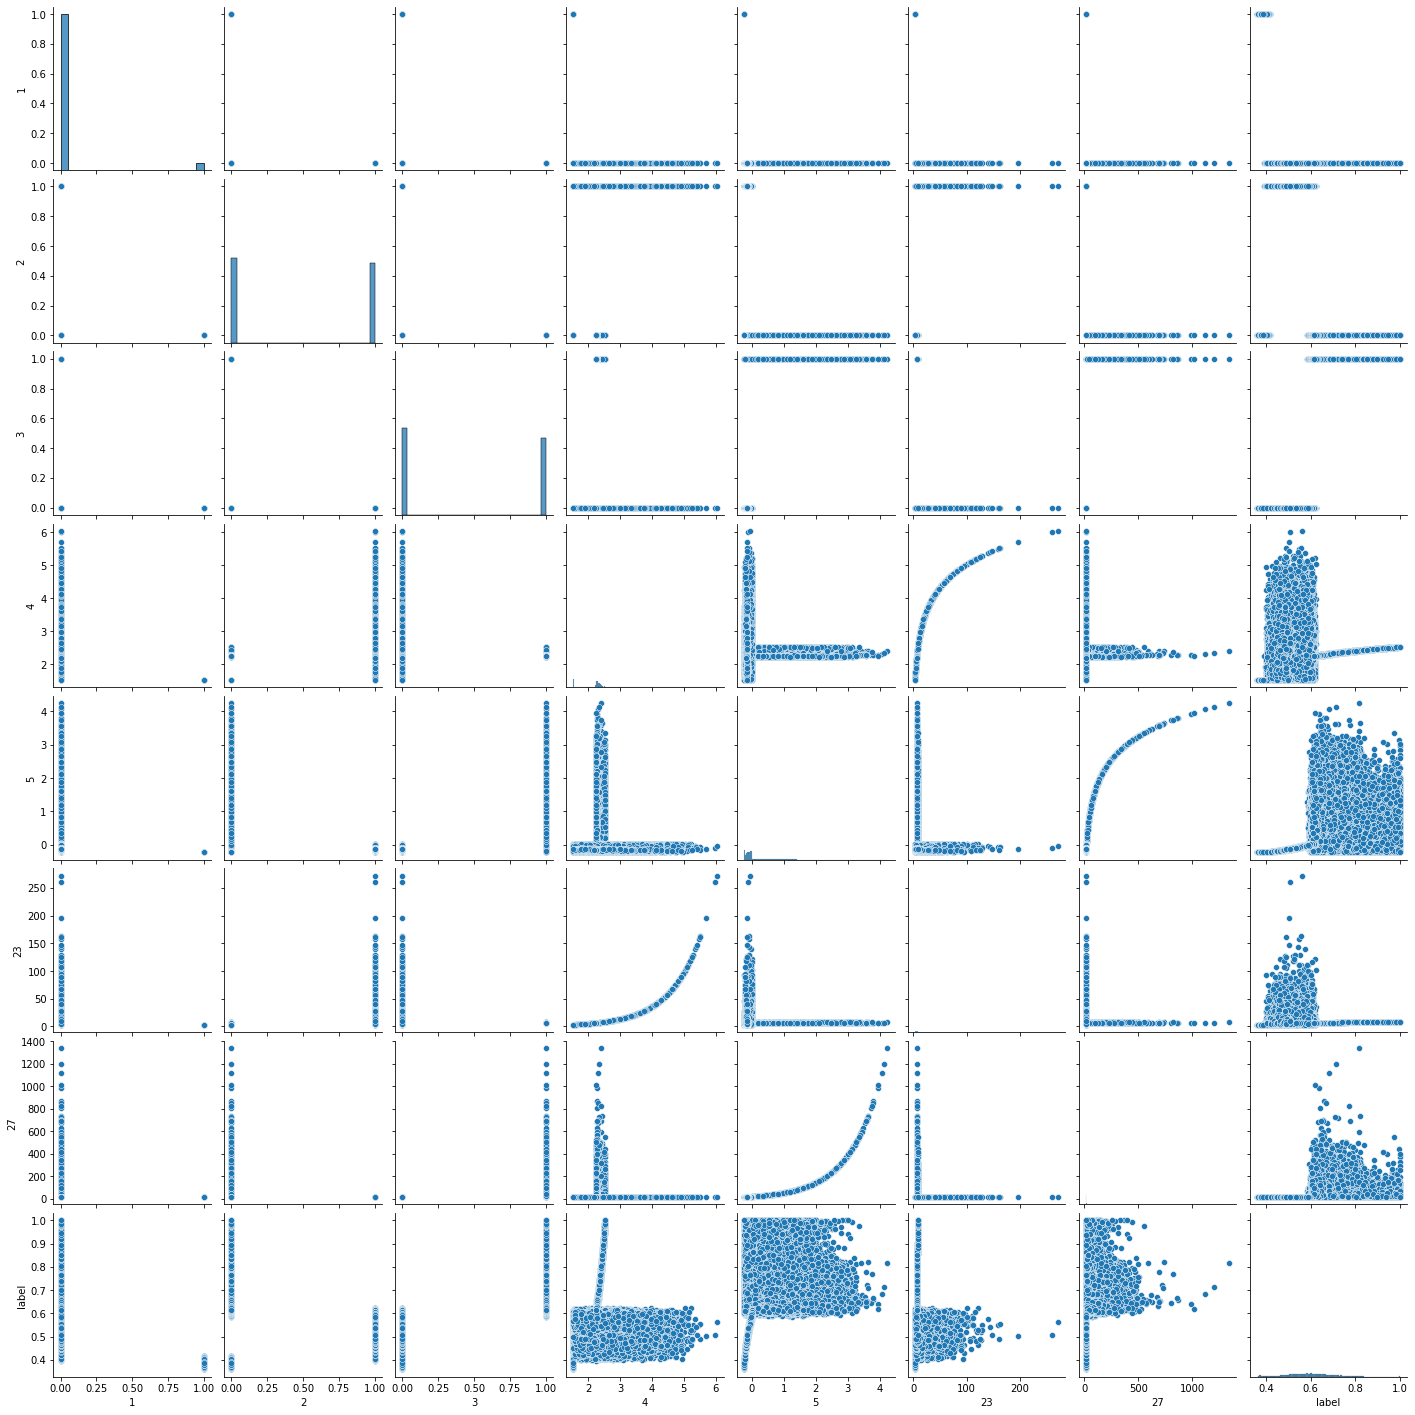

In [250]:
sns.pairplot(pd.concat((train_X, train_Y), axis=1))

В пересечении клеток 4, 5 и 23, 27 видно, что что-то из них можно дропнуть нафиг

In [251]:
train_X.drop(columns=[23, 27], inplace=True)
test_X.drop(columns=[23, 27], inplace=True)

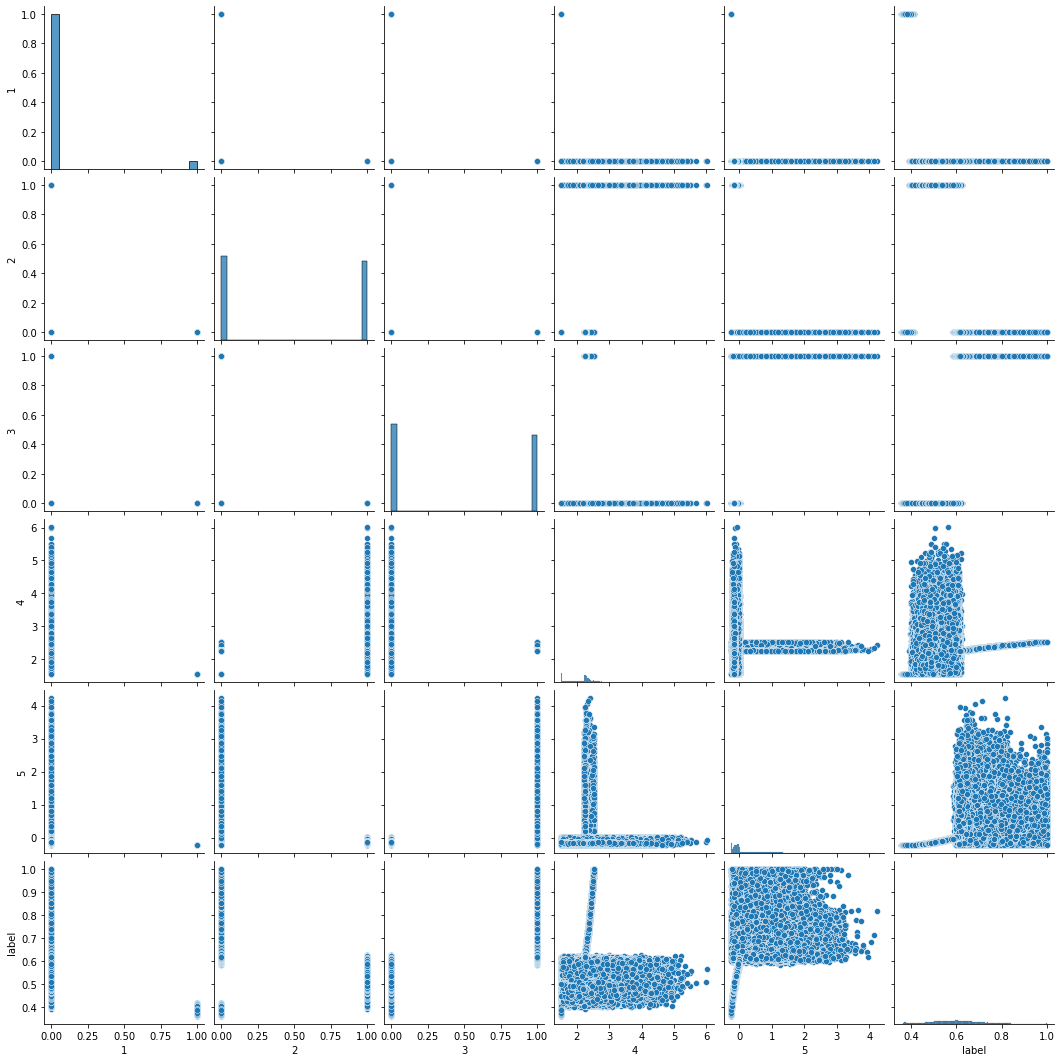

In [252]:
sns.pairplot(pd.concat((train_X, train_Y), axis=1))

аутлайеров дофига почему-то + можно дропнуть X1, ибо он ЛЗ от X2 и X3

### Новая моделька с новыми признаками

In [255]:
X_train = train_X.rename(columns = {i: f'X{i}' for i in range(1, 6)})

In [263]:
model_new = smf.ols('label ~ X2 + X3 + X4 + X5 + X3:X5 + X3:X4 + X2:X4', data=pd.concat((X_train, train_Y), axis=1)).fit()

In [264]:
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.631e+06
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:04:01   Log-Likelihood:             5.4518e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172737   BIC:                        -1.090e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3810      0.000   -992.917      0.000      -0.382      -0.380
X2             0.9824      0.000   2512.359      0.000       0.982       0.983
X3            -1.7707      0.001  -1996.675      0.000      -1.772      -1.769
X4             0.6168      0.000   2378.030      0.000       0.616       0.617
X5             0.7517      0.001   1352.967      0.000       0.751       0.753
X3:X5         -0.7516      0.001  -1344.958      0.000      -0.753      -0.751
X3:X4          0.6132      0.000   2003.030      0.000       0.613       0.614
X2:X4         -0.6168      0.000  -2372.675      0.000      -0.617      -0.616
==============================================================================
Omnibus:                    28509.516   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97130.865
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       6.278   Cond. No.                     2.85e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.04e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [268]:
pred = model_new.predict(test_X.rename(columns = {i: f'X{i}' for i in range(1, 6)}))
test_Y = np.reshape(pred.values, (-1, regression_x_test.shape[1]))

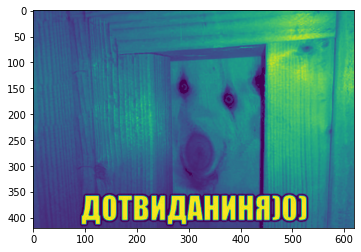

In [271]:
plt.imshow(test_Y)
plt.show()

Шутка длиною в кучу моего времени

# Задание 6 (сделано)
## Задача 6.1

Рассмотрим задачу предсказание числа заболевших некоторой болезнью от некоторых экологических анализов (см. [файл](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab1/data/sick.csv)). Гарантируется, что предсказание описывается линейной моделью.

Так как проведение анализов не является бесплатным, то стоит вопрос о том какие из анализов являются лишними (на уровне значимости $\alpha=0.05$) для предсказания линейной модели.

Требуется:

1. Записать задачу формально;
2. Провести отбор признаков линейной модели.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компьютера для подстановвки численых значений в финальную формулу)

In [272]:
!mkdir data/sick
!wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/sick.csv -O data/sick/sick.csv

--2021-04-05 18:15:59--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/labs/lab1/data/sick.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1496 (1.5K) [text/plain]
Saving to: ‘data/sick/sick.csv’

data/sick/sick.csv  100%[===================>]   1.46K  --.-KB/s    in 0s      

2021-04-05 18:15:59 (17.2 MB/s) - ‘data/sick/sick.csv’ saved [1496/1496]



In [275]:
sick = pd.read_csv('data/sick/sick.csv')
sick.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Y
0,-0.5,-0.1,-1.2,-0.6,-1.1,1.4,-1.4,1.2,-0.2,-0.2,0.0
1,1.0,0.4,0.5,-1.1,0.6,-0.1,-0.2,-0.7,-0.5,0.4,1.0
2,0.3,-0.9,0.8,-0.3,-0.2,-1.4,0.4,1.6,1.0,-0.3,3.0
3,-1.1,-0.5,0.5,1.8,0.3,-0.3,-0.1,0.4,1.0,0.3,3.0
4,1.9,0.6,0.4,0.7,-2.9,0.5,-0.9,-1.5,0.9,-3.1,1.0


In [276]:
sick.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Y
count,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000
mean,-0.060000,-0.190000,0.29000,0.146667,0.093333,0.423333,0.07000,0.236667,-0.013333,0.023333,2.700000
std,1.178134,1.071367,0.80915,1.219591,0.947568,0.981091,0.93593,1.114940,0.976882,1.101311,3.260527
min,-2.200000,-1.900000,-1.20000,-1.700000,-2.900000,-1.800000,-1.80000,-1.600000,-1.800000,-3.100000,0.000000
25%,-0.850000,-0.900000,-0.27500,-1.000000,-0.475000,-0.275000,-0.47500,-0.775000,-0.475000,-0.450000,1.000000
50%,-0.250000,-0.450000,0.25000,0.500000,0.100000,0.450000,-0.10000,0.250000,0.000000,0.050000,1.000000
75%,0.450000,0.400000,0.77500,0.950000,0.750000,1.175000,0.70000,1.075000,0.625000,0.725000,3.000000
max,2.400000,2.000000,2.00000,2.500000,2.100000,2.200000,2.20000,2.300000,2.300000,2.000000,14.000000


### Формализация
Сделать линрег по МНК (эту формулу знают все, камон)

In [294]:
string = 'Y ~ ' + reduce(lambda a, x: f'{a} + x{x}', range(1, 11))

model = GLM.from_formula(string, data=sick).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       20
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          5.1282
Method:                          IRLS   Log-Likelihood:                -61.008
Date:                Mon, 05 Apr 2021   Deviance:                       102.56
Time:                        20:26:50   Pearson chi2:                     103.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0710      0.536      3.860      0.000       1.019       3.122
x2             0.1565      0.494      0.317      0.752      -0.813       1.126
x3             3.0262      0.579      5.227      0.000       1.891       4.161
x4             0.4119      0.390      1.055      0.291      -0.353       1.177
x5            -0.2716      0.542     -0.502      0.616      -1.333       0.790
x6            -0.3948      0.473     -0.834      0.404      -1.322       0.532
x7            -0.3514      0.482     -0.729      0.466      -1.296       0.593
x8            -0.3111      0.466     -0.667      0.505      -1.225       0.603
x9            -0.0341      0.504     -0.068      0.946      -1.021       0.953
x10            0.4712      0.558      0.845      0.398      -0.622       1.564
==============================================================================
"""

### Отберём признаки критерием Фишера
Классика эконометрики, чё сказать

Пусть ESS = $\displaystyle\sum_{i = 1}^{n} (\hat{y_i} - \overline{y_i})^2 $

Рассмотрим $Con_{new} = ESS_{new} - ESS$: вклад новой переменной $x_{new}$ в объясняющую способность модели. Порог вклада определим по крит. Фишера

$RSS = \displaystyle\sum_{i = 1}^{n} (y_i - \hat{y_i})^2$

### А как?
Выберем наиболее скоррелированный с эндогенной переменной признак, оценим его значимость критерием. Если гипотеза подтверждена, то больше не отбираем, иначе закинем его в модель.

Посчитаем для того что осталось статистику и возьмём признак с максимумом этой статистики, опять проверим на значимость признак.

In [302]:
corr_list = list(map(lambda x: pearsonr(sick[f'x{x}'], sick['Y'])[0], range(1, 11)))
print(f'{corr_list.index(max(corr_list))}: {max(corr_list)}')

2: 0.7856548401848727


Третий элемент (с индексом 2) имеет макс. значение. Тогда построим модель $y = \gamma + \beta * x_3$

In [304]:
X_mean = sick['x3'].mean()
Y_mean = sick['Y'].mean()

X = np.array(sick['x3'])
Y = np.array(sick['Y'])
num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
beta = num / den
gamma = Y_mean - beta * X_mean
 
y_new = gamma + beta * X

print (f'gamma = {gamma}, beta = {beta}')

gamma = 1.7819034075946703, beta = 3.1658503186390687


$Con(x_3) = 190.27, T = 45.14$. $F(1,28)_{1 - \alpha} = 4.20$, выходит что из $F(1.28)_{1 - \alpha} < T$ следует, что признак $x_3$ значим.

Рассчитаем $T$ для остальных признаков

$x_1: 6.25$

$x_2: 0.35$

$x_4: 0.89$

$x_5: 0.36$

$x_6: 0.63$

$x_7: 0.22$

$x_8: 0.09$

$x_9: 0.02$

$x_{10}: 0.06$

Максимум в $x_1$. Проверили значимость, вышло что он значим, добавили в модель. Модель выходит такой: $y = \gamma + \sum_{i}\beta_i x_i \quad i \in \{1, 3\}$

Рассчитываем $T$

$x_2: 0.42$

$x_4: 1.67$

$x_5: 0.07$

$x_6: 0.90$

$x_7: 0.34$

$x_8: 0.22$

$x_9: 0.02$

$x_{10}: -0.01$

Проверяем $x_4$ на значимость, выходит что данные не противоречат, поэтому остальные переменные можно отбросить.

т.о. критерием Фишера выяснили, что $x_1$ и $x_3$ значимы.

In [306]:
model = GLM.from_formula('Y ~ x1 * x3', data=sick).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       26
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          2.7708
Method:                          IRLS   Log-Likelihood:                -55.709
Date:                Mon, 05 Apr 2021   Deviance:                       72.041
Time:                        20:53:30   Pearson chi2:                     72.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6900      0.324      5.211      0.000       1.054       2.326
x1            -0.4300      0.283     -1.518      0.129      -0.985       0.125
x3             3.4223      0.390      8.780      0.000       2.658       4.186
x1:x3         -0.8248      0.281     -2.932      0.003      -1.376      -0.273
==============================================================================
"""